In [1]:
import os
import textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec

In [ ]:
# ============================================================
# 0) Theme + utilities (single source of truth)
# ============================================================

# --- Palette (CommBank-ish) ---
CBA_YELLOW = "#FFCC00"
CBA_BLACK  = "#000000"
DARK_GREY  = "#333333"
MID_GREY   = "#666666"
LIGHT_GREY = "#D9D9D9"
BG_WHITE   = "#FFFFFF"

# Consistent mode ordering (used across charts)
MODE_ORDER = [
    "PRIVATE_VEHICLE",
    "PUBLIC_TRANSPORT",
    "WFH",
    "MIXED_PT_PRIVATE",
    "ACTIVE_TRANSPORT",
    "OTHER",
]

# Colors for MODE_ORDER (NSW/Transport palette)
MODE_COLORS = {
    "PRIVATE_VEHICLE":   "#24408E",
    "PUBLIC_TRANSPORT":  "#00B7BD",
    "WFH":               "#E6332A",
    "MIXED_PT_PRIVATE":  "#8A2BE2",
    "ACTIVE_TRANSPORT":  "#4CAF50",
    "OTHER":             "#A9A9A9",
}


def set_cba_theme() -> None:
    """Apply a clean slide-friendly matplotlib theme."""
    plt.rcParams.update({
        "figure.facecolor": BG_WHITE,
        "axes.facecolor": BG_WHITE,
        "axes.edgecolor": LIGHT_GREY,
        "axes.labelcolor": DARK_GREY,
        "xtick.color": MID_GREY,
        "ytick.color": MID_GREY,
        "text.color": DARK_GREY,
        "axes.titleweight": "bold",
        "axes.titlepad": 12,
        "font.size": 12,
        "axes.grid": True,
        "grid.color": LIGHT_GREY,
        "grid.linewidth": 0.8,
        "grid.alpha": 0.8,
        "legend.frameon": False,
    })


def clean_axes(ax: plt.Axes) -> None:
    """Minimal frame + y-grid only (slide style)."""
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(axis="x", visible=False)
    ax.set_axisbelow(True)


def wrap_labels(labels, width: int = 24):
    return [textwrap.fill(str(x), width=width) for x in labels]


def save_slide_fig(fig: plt.Figure, filename: str, out_dir: str = "slide_figs") -> None:
    """Save high-DPI figures for slides."""
    os.makedirs(out_dir, exist_ok=True)
    path = os.path.join(out_dir, filename)
    fig.savefig(path, dpi=300, bbox_inches="tight", facecolor=BG_WHITE)
    print(f"Saved: {path}")


def load_csv(path: str, upper_cols: bool = False) -> pd.DataFrame:
    """
    Load CSV and standardise column names.

    upper_cols=False => lower-case columns (pythonic)
    upper_cols=True  => upper-case columns (closer to raw SQL exports)
    """
    df = pd.read_csv(path)
    if upper_cols:
        df.columns = df.columns.str.strip().str.upper()
    else:
        df.columns = df.columns.str.strip().str.lower()
    return df


def pick_col(candidates, cols):
    """Pick first matching column name from candidates."""
    return next((c for c in candidates if c in cols), None)


def pivot_mode_shares(file: str, share_col: str, index_cols):
    """
    Convert long format (year/region/mode_group/share) into wide format by mode.

    Ensures:
    - MODE_GROUP normalised to UPPER
    - share values are in [0,1] (auto-divide by 100 if needed)
    - columns returned in MODE_ORDER (missing filled with 0)
    """
    df = load_csv(file, upper_cols=True)

    # Mode group field is expected for these files
    df["MODE_GROUP"] = df["MODE_GROUP"].astype(str).str.strip().str.upper()

    pivot = (
        df.pivot_table(index=index_cols, columns="MODE_GROUP", values=share_col)
          .fillna(0.0)
    )

    # If stored as 0–100, convert to 0–1
    if pivot.max().max() > 1.1:
        pivot = pivot / 100.0

    return pivot.reindex(columns=MODE_ORDER, fill_value=0.0)


def donut(ax: plt.Axes, values, colors, title: str, label_threshold: float = 0.06):
    """
    Draw a donut chart with percentage labels above a threshold.

    label_threshold: show labels only if slice >= threshold (0–1).
    """
    values = np.array(values, dtype=float)
    total = values.sum()

    ax.set(aspect="equal")
    ax.set_title(title, fontsize=12, fontweight="bold", pad=12)

    if total <= 0:
        ax.text(0.5, 0.5, "No data", ha="center", va="center")
        ax.axis("off")
        return

    def autopct(pct):
        return f"{pct:.0f}%" if (pct / 100.0) >= label_threshold else ""

    ax.pie(
        values,
        colors=colors,
        startangle=90,
        counterclock=False,
        wedgeprops=dict(width=0.45, edgecolor="white", linewidth=0.8),
        autopct=autopct,
        pctdistance=0.78,
        textprops=dict(color="white", fontweight="bold", fontsize=10),
    )


# Activate global theme once
set_cba_theme()

V_METRIC_MODE_TREND_NSW_PIVOT columns: ['census_year', 'pt_commuters', 'private_commuters', 'wfh_commuters', 'active_commuters', 'mixed_commuters', 'other_commuters', 'total_commuters', 'pt_share', 'private_share', 'wfh_share', 'active_share', 'mixed_share', 'other_share']


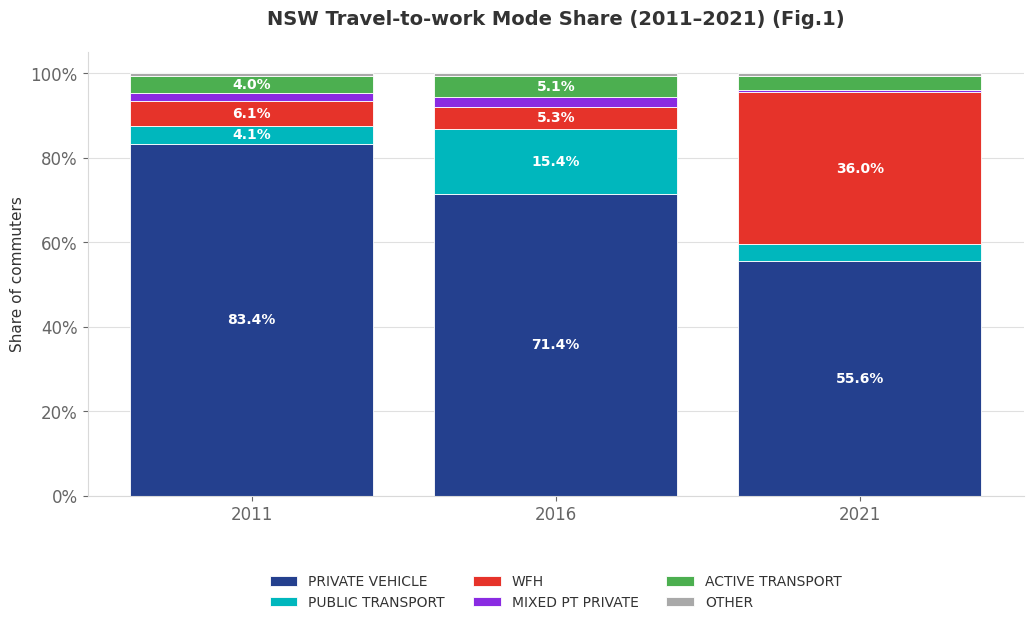

In [ ]:
# ============================================================
# 1) Fig.1 — NSW Travel-to-work Mode Share (2011–2021) (stacked) (Picked for slide)
# ============================================================

# ---- Load + quick check (kept from your original blocks) ----
df_mode_pivot = load_csv("V_METRIC_MODE_TREND_NSW_PIVOT.csv", upper_cols=False)
print("V_METRIC_MODE_TREND_NSW_PIVOT columns:", df_mode_pivot.columns.tolist())

# Ensure numeric shares are in 0–1 if the CSV ever exports 0–100
share_cols = ["private_share", "pt_share", "wfh_share", "mixed_share", "active_share", "other_share"]
if df_mode_pivot[share_cols].max().max() > 1.1:
    df_mode_pivot[share_cols] = df_mode_pivot[share_cols] / 100.0

df_mode_pivot = df_mode_pivot.sort_values("census_year")
years = df_mode_pivot["census_year"].astype(int).tolist()
xlabels = [str(y) for y in years]

# Map wide columns -> mode names used elsewhere
WIDE_TO_MODE = {
    "private_share": "PRIVATE_VEHICLE",
    "pt_share": "PUBLIC_TRANSPORT",
    "wfh_share": "WFH",
    "mixed_share": "MIXED_PT_PRIVATE",
    "active_share": "ACTIVE_TRANSPORT",
    "other_share": "OTHER",
}

df_plot = pd.DataFrame(index=years)
for wide_col, mode in WIDE_TO_MODE.items():
    df_plot[mode] = df_mode_pivot[wide_col].values if wide_col in df_mode_pivot.columns else 0.0
df_plot = df_plot.reindex(columns=MODE_ORDER, fill_value=0.0)

fig, ax = plt.subplots(figsize=(10.5, 6.5))
bottom = np.zeros(len(df_plot))

for mode in MODE_ORDER:
    vals = df_plot[mode].values
    if vals.sum() == 0:
        continue

    ax.bar(
        xlabels,
        vals,
        bottom=bottom,
        label=mode.replace("_", " ").upper(),
        color=MODE_COLORS[mode],
        edgecolor="white",
        linewidth=0.6,
    )

    # Segment labels (same threshold logic as your original)
    for i, val in enumerate(vals):
        if val > 0.04:
            ax.text(
                i,
                bottom[i] + val / 2,
                f"{val*100:.1f}%",
                ha="center",
                va="center",
                color="white",
                fontweight="bold",
                fontsize=10,
            )

    bottom += vals

ax.set_title("NSW Travel-to-work Mode Share (2011–2021) (Fig.1)", fontsize=14, fontweight="bold", pad=20)
ax.set_ylabel("Share of commuters", fontsize=11)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.legend(ncol=3, loc="upper center", bbox_to_anchor=(0.5, -0.15), fontsize=10)
clean_axes(ax)

plt.tight_layout()
plt.show()


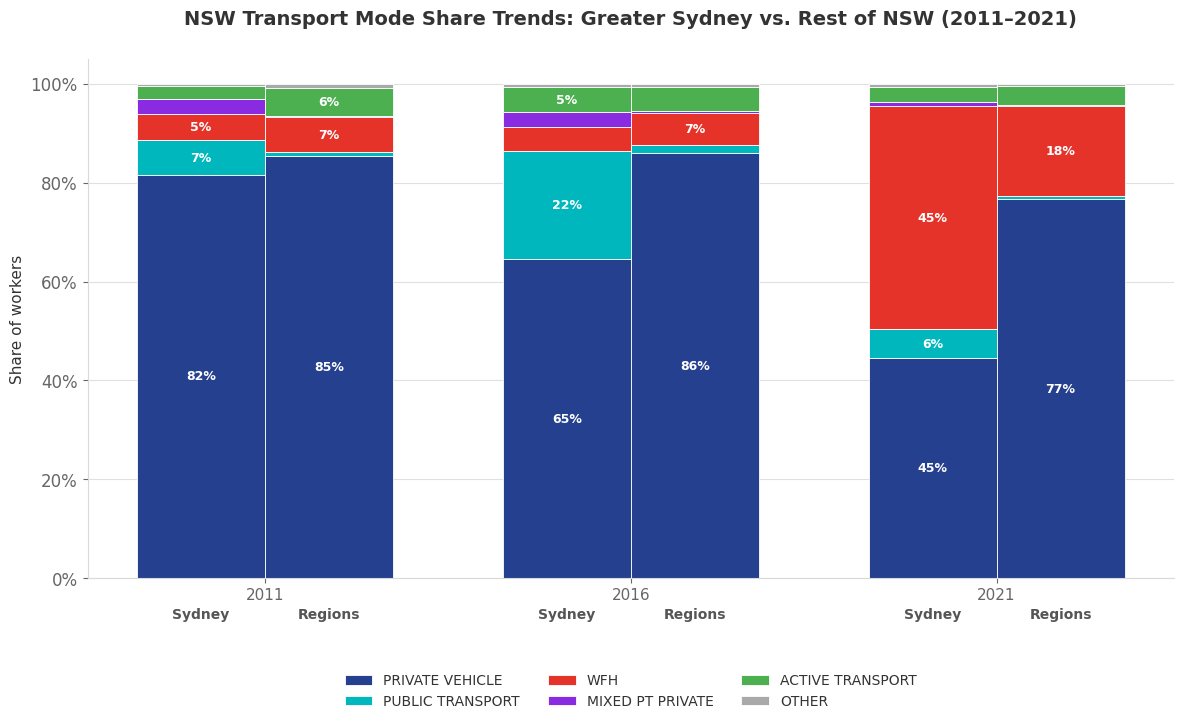

In [ ]:
# ============================================================
# 2) Regional divergence (Sydney vs Rest of NSW) (stacked)
# ============================================================

df_reg_pivot = pivot_mode_shares(
    file="V_METRIC_REGIONAL_MODE_TREND_NSW.csv",
    share_col="REGIONAL_MODE_SHARE",
    index_cols=["CENSUS_YEAR", "REGION"]
)

# Keep only the two regions used in your chart
regions = ["Greater Sydney", "Rest of NSW"]
df_reg_pivot = df_reg_pivot.loc[df_reg_pivot.index.get_level_values("REGION").isin(regions)]

years = sorted(df_reg_pivot.index.get_level_values("CENSUS_YEAR").unique())
x = np.arange(len(years))
width = 0.35

fig1, ax1 = plt.subplots(figsize=(12, 7.5))

for i, region in enumerate(regions):
    bottom = np.zeros(len(years))
    pos = x + (i - 0.5) * width

    for mode in MODE_ORDER:
        vals = np.array([df_reg_pivot.loc[(y, region), mode] for y in years], dtype=float)
        ax1.bar(
            pos,
            vals,
            width=width,
            bottom=bottom,
            label=mode.replace("_", " ").upper() if i == 0 else "",
            color=MODE_COLORS[mode],
            edgecolor="white",
            linewidth=0.6,
        )

        # Labels (threshold kept)
        for j, val in enumerate(vals):
            if val > 0.05:
                ax1.text(
                    pos[j],
                    bottom[j] + val / 2,
                    f"{val*100:.0f}%",
                    ha="center",
                    va="center",
                    color="white",
                    fontweight="bold",
                    fontsize=9,
                )

        bottom += vals

ax1.set_title(
    "NSW Transport Mode Share Trends: Greater Sydney vs. Rest of NSW (2011–2021)",
    fontsize=14,
    fontweight="bold",
    pad=25,
)
ax1.set_ylabel("Share of workers", fontsize=11)
ax1.set_xticks(x)
ax1.set_xticklabels([str(y) for y in years], fontsize=11)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Region labels under each year (same as your original placement)
for i, _y in enumerate(years):
    ax1.text(i - 0.175, -0.06, "Sydney",  ha="center", va="top", fontsize=10, fontweight="bold", color="#555555")
    ax1.text(i + 0.175, -0.06, "Regions", ha="center", va="top", fontsize=10, fontweight="bold", color="#555555")

ax1.legend(ncol=3, loc="upper center", bbox_to_anchor=(0.5, -0.16), fontsize=10)
clean_axes(ax1)

plt.tight_layout()
plt.show()

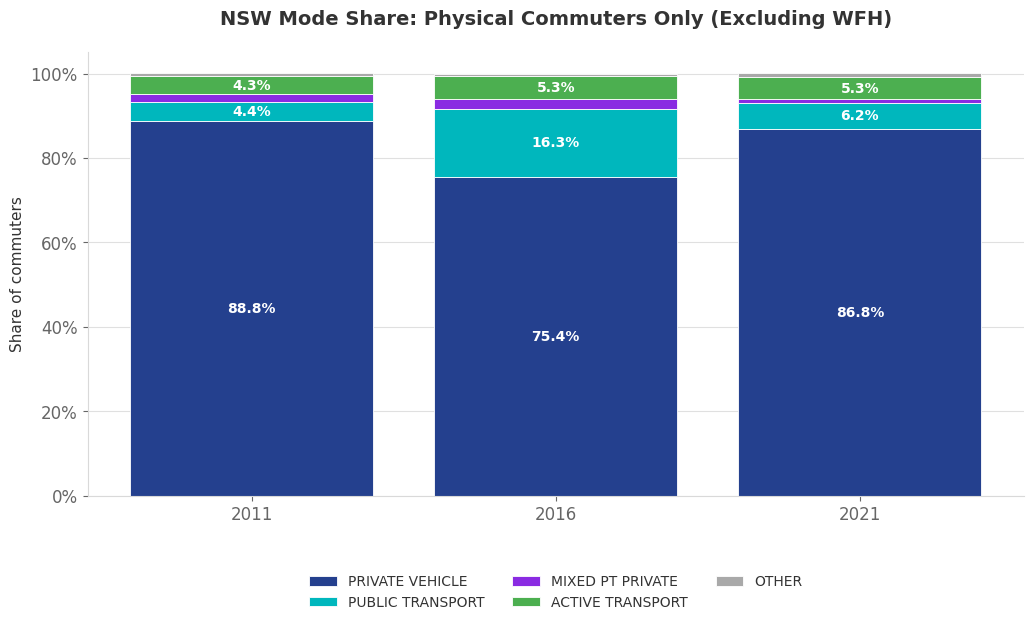

In [ ]:
# ============================================================
# 3) Physical commuters only (Excluding WFH) (stacked)
# ============================================================

df_phys_pivot = pivot_mode_shares(
    file="V_METRIC_PHYSICAL_COMMUTER_TREND_NSW.csv",
    share_col="COMMUTER_MODE_SHARE",
    index_cols="CENSUS_YEAR"
)

fig2, ax2 = plt.subplots(figsize=(10.5, 6.5))
years_phys = [str(y) for y in df_phys_pivot.index]
bottom_phys = np.zeros(len(df_phys_pivot))

physical_modes = [m for m in MODE_ORDER if m != "WFH"]

for mode in physical_modes:
    vals = df_phys_pivot[mode].values
    if vals.sum() == 0:
        continue

    ax2.bar(
        years_phys,
        vals,
        bottom=bottom_phys,
        label=mode.replace("_", " ").upper(),
        color=MODE_COLORS[mode],
        edgecolor="white",
        linewidth=0.6,
    )

    for i, val in enumerate(vals):
        if val > 0.04:
            ax2.text(
                i,
                bottom_phys[i] + val / 2,
                f"{val*100:.1f}%",
                ha="center",
                va="center",
                color="white",
                fontweight="bold",
                fontsize=10,
            )

    bottom_phys += vals

ax2.set_title("NSW Mode Share: Physical Commuters Only (Excluding WFH)", fontsize=14, fontweight="bold", pad=20)
ax2.set_ylabel("Share of commuters", fontsize=11)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax2.legend(ncol=3, loc="upper center", bbox_to_anchor=(0.5, -0.15), fontsize=10)
clean_axes(ax2)

plt.tight_layout()
plt.show()

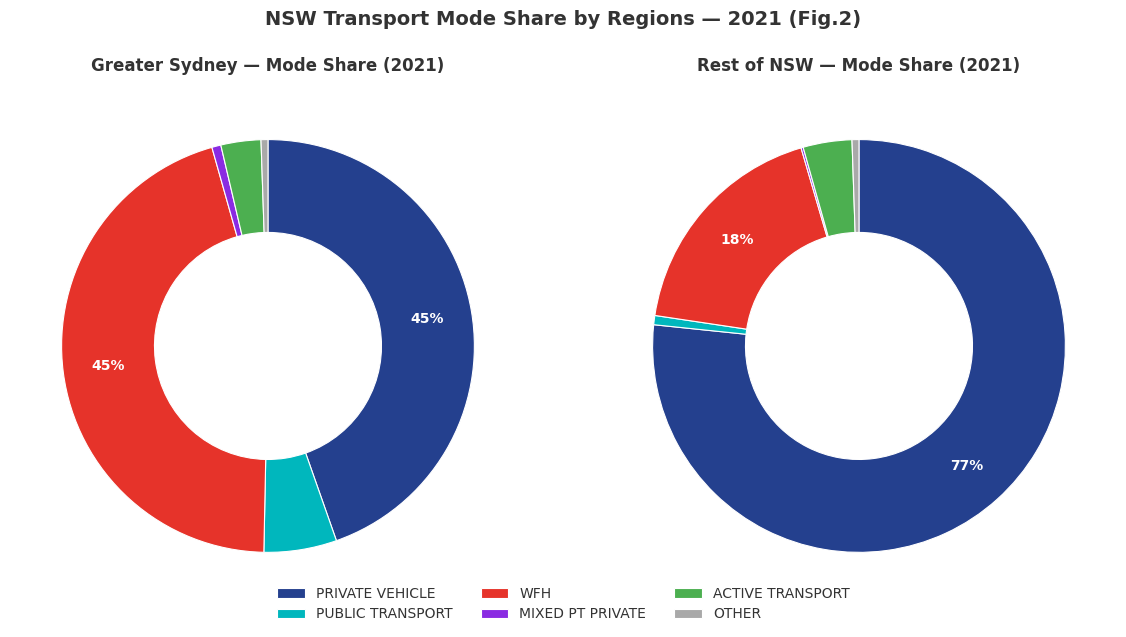

In [ ]:
# ============================================================
# 4) Fig.2 — Donut charts for regional mode share in 2021 (Picked for slide)
# ============================================================

year_target = 2021

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for ax, region in zip(axes, regions):
    vals = df_reg_pivot.loc[(year_target, region), MODE_ORDER].values
    donut(
        ax=ax,
        values=vals,
        colors=[MODE_COLORS[m] for m in MODE_ORDER],
        title=f"{region} — Mode Share ({year_target})",
        label_threshold=0.06,
    )

legend_labels = [m.replace("_", " ").upper() for m in MODE_ORDER]
fig.legend(
    handles=axes[0].patches[:len(MODE_ORDER)],
    labels=legend_labels,
    loc="lower center",
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.5, -0.02),
    fontsize=10,
)

fig.suptitle(f"NSW Transport Mode Share by Regions — {year_target} (Fig.2)", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

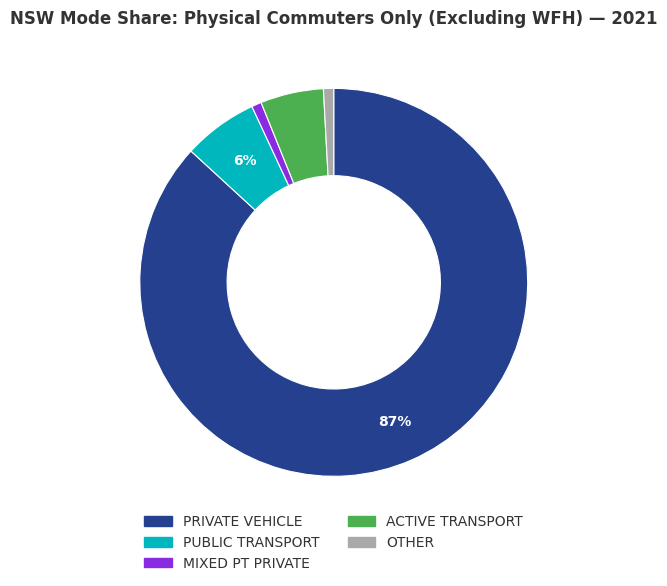

In [8]:
# ============================================================
# 5) Donut — Physical commuters only (Excluding WFH) in 2021
# ============================================================

vals_phys = df_phys_pivot.loc[year_target, physical_modes].values.astype(float)
vals_phys = vals_phys / vals_phys.sum() if vals_phys.sum() > 0 else vals_phys

fig, ax = plt.subplots(figsize=(7, 6))
donut(
    ax=ax,
    values=vals_phys,
    colors=[MODE_COLORS[m] for m in physical_modes],
    title=f"NSW Mode Share: Physical Commuters Only (Excluding WFH) — {year_target}",
    label_threshold=0.06,
)

ax.legend(
    [plt.Rectangle((0, 0), 1, 1, color=MODE_COLORS[m]) for m in physical_modes],
    [m.replace("_", " ").upper() for m in physical_modes],
    loc="lower center",
    ncol=2,
    frameon=False,
    bbox_to_anchor=(0.5, -0.12),
    fontsize=10,
)

plt.tight_layout()
plt.show()

V_METRIC_WFH_GROWTH_SA2_NSW columns: ['sa2_res_code', 'sa2_res_name_std', 'wfh_rate_2011', 'wfh_rate_2016', 'wfh_rate_2021', 'wfh_pp_change_11_16', 'wfh_pp_change_16_21']


/var/folders/7h/wqb_r57s64j5_1ymz9465t8m0000gn/T/ipykernel_47582/3495287721.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([wfh_2011, wfh_2016, wfh_2021], labels=["2011", "2016", "2021"], showfliers=False)


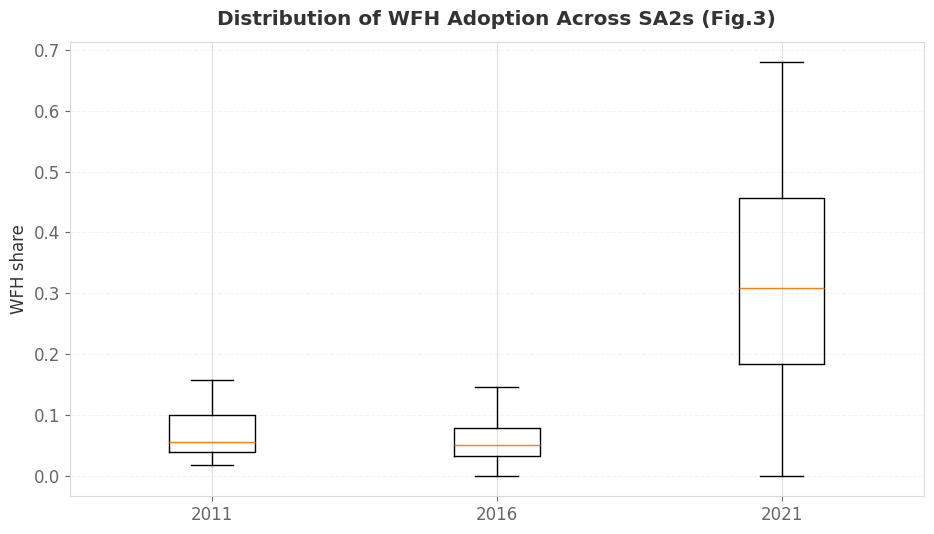

In [ ]:
# ============================================================
# 6) Fig.3 — WFH adoption distribution across SA2s (boxplot) (Picked for slide)
# ============================================================

df_wfh_growth = load_csv("V_METRIC_WFH_GROWTH_SA2_NSW.csv", upper_cols=False)
print("V_METRIC_WFH_GROWTH_SA2_NSW columns:", df_wfh_growth.columns.tolist())

# Use your explicit column names (if export matches the SQL view)
wfh_2011 = df_wfh_growth["wfh_rate_2011"].dropna()
wfh_2016 = df_wfh_growth["wfh_rate_2016"].dropna()
wfh_2021 = df_wfh_growth["wfh_rate_2021"].dropna()

plt.figure(figsize=(9.5, 5.5))
plt.boxplot([wfh_2011, wfh_2016, wfh_2021], labels=["2011", "2016", "2021"], showfliers=False)
plt.ylabel("WFH share")
plt.title("Distribution of WFH Adoption Across SA2s (Fig.3)", fontweight="bold")
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

Using WFH change column: wfh_pp_change_16_21


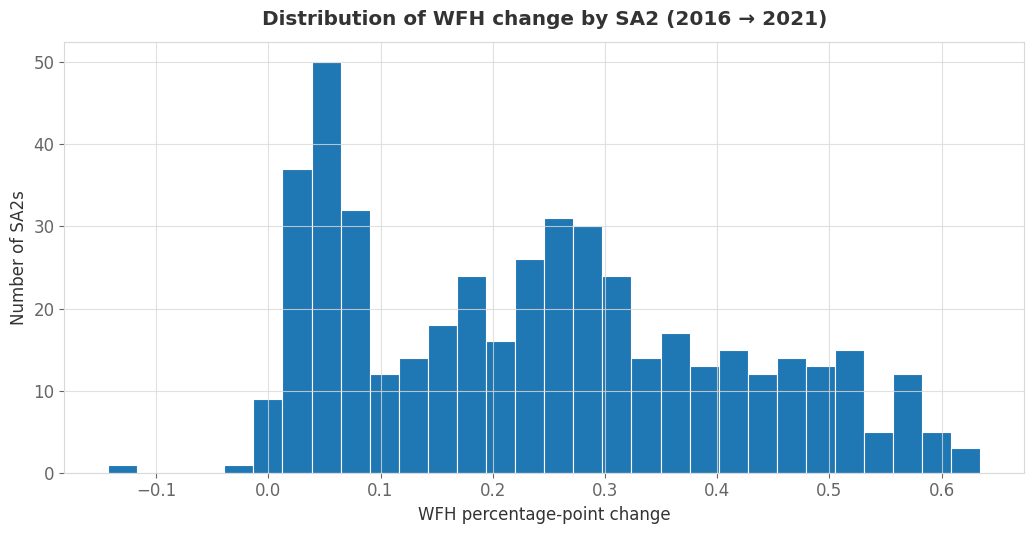

In [ ]:
# ============================================================
# 7) WFH change distribution (hist) — 2016 -> 2021
# ============================================================

# Candidate column names
pp_candidates = [
    "wfh_pp_change_16_21",
    "wfh_pp_change_2016_2021",
    "wfh_rate_pp_change_16_21",
    "wfh_rate_change_16_21",
    "wfh_change_16_21",
    "wfh_delta_16_21",
]
pp_col = next((c for c in pp_candidates if c in df_wfh_growth.columns), None)

if pp_col is None:
    likely = [c for c in df_wfh_growth.columns if ("wfh" in c or "21" in c or "change" in c or "pp" in c)]
    raise ValueError(
        "Could not find a WFH change column. "
        f"Columns that look relevant: {likely}"
    )

print("Using WFH change column:", pp_col)

vals = df_wfh_growth[pp_col].dropna().values

plt.figure(figsize=(10.5, 5.5))
plt.hist(vals, bins=30, edgecolor="white", linewidth=0.8)
plt.title("Distribution of WFH change by SA2 (2016 → 2021)")
plt.xlabel("WFH percentage-point change")
plt.ylabel("Number of SA2s")
plt.tight_layout()
plt.show()

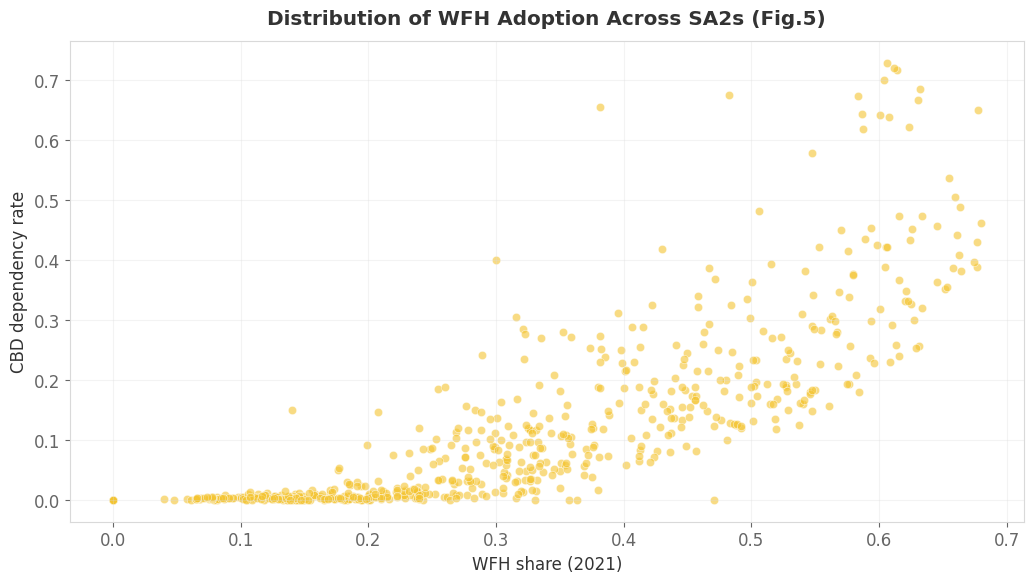

In [16]:
# ============================================================
# 8) Fig.5 — Scatter: WFH (2021) vs CBD dependency (2021) (picked for slide)
# ============================================================

df_cbd = load_csv("V_METRIC_CBD_VOLUME_NSW.csv", upper_cols=False)

df_scatter = df_cbd.merge(
    df_wfh_growth[["sa2_res_code", "wfh_rate_2021"]],
    on="sa2_res_code",
    how="left",
)

df_2021 = df_scatter[df_scatter["census_year"] == 2021].dropna(subset=["wfh_rate_2021", "cbd_dependency_rate"])

dark_gold = "#F4C430"

plt.figure(figsize=(10.5, 6))
plt.scatter(
    df_2021["wfh_rate_2021"],
    df_2021["cbd_dependency_rate"],
    color=dark_gold,
    alpha=0.6,
    edgecolor="white",
    linewidth=0.5,
)
plt.xlabel("WFH share (2021)")
plt.ylabel("CBD dependency rate")
plt.title("Distribution of WFH Adoption Across SA2s (Fig.5)", fontweight="bold")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

V_METRIC_BUS_CANDIDATE_2021_NSW_normalized columns: ['census_year', 'sa2_res_code', 'sa2_res_name_std', 'cbd_commuters', 'cbd_dependency_rate', 'pt_share', 'wfh_share', 'mixed_share', 'total_commuters', 'cbd_growth_rate_16_21', 'bus_candidate_score']
Using score column: bus_candidate_score
Using name column: sa2_res_name_std


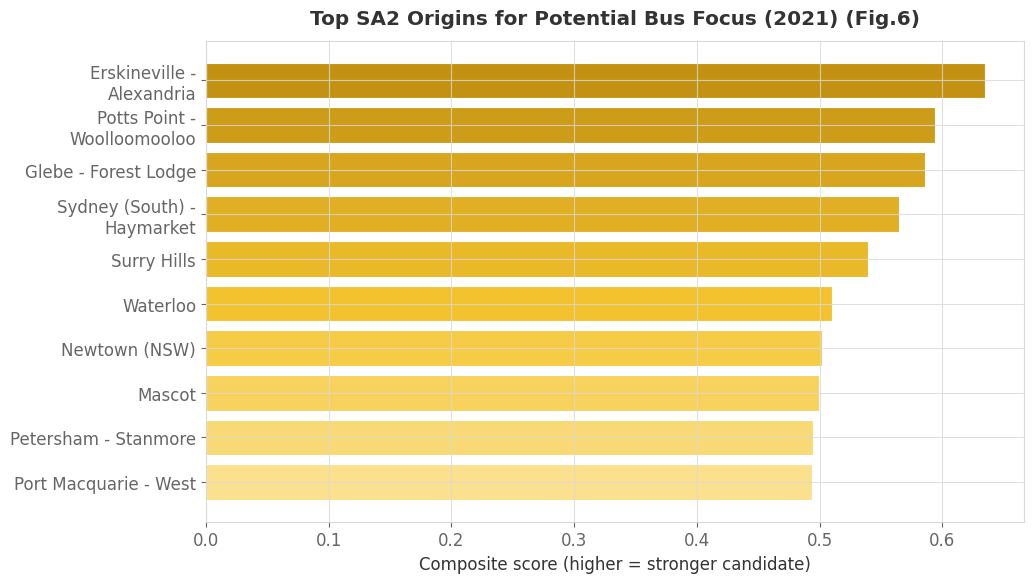

In [ ]:
# ============================================================
# 9) Fig.6 — Top bus candidates (Picked for slide)
# ============================================================

df_bus_norm = load_csv("V_METRIC_BUS_CANDIDATE_2021_NSW_normalized.csv", upper_cols=False)
print("V_METRIC_BUS_CANDIDATE_2021_NSW_normalized columns:", df_bus_norm.columns.tolist())

score_col = pick_col(["bus_candidate_score", "bus_score", "candidate_score", "score"], df_bus_norm.columns)
name_col = pick_col(["sa2_res_name_std", "sa2_res_name", "sa2_name", "sa2_residence"], df_bus_norm.columns)

if score_col is None:
    possible = [c for c in df_bus_norm.columns if "score" in c]
    raise ValueError(f"Could not find score column. Possible: {possible}")

if name_col is None:
    possible = [c for c in df_bus_norm.columns if ("name" in c or "sa2" in c)]
    raise ValueError(f"Could not find SA2 name column. Possible: {possible}")

print("Using score column:", score_col)
print("Using name column:", name_col)

top = df_bus_norm.sort_values(score_col, ascending=False).head(10)

# Gold gradient palette
base_color = "#F4C430"
cmap = mcolors.LinearSegmentedColormap.from_list("gold_gradient", ["#FFF4CC", base_color, "#B8860B"])
palette = [cmap(i) for i in np.linspace(0.9, 0.2, len(top))]

plt.figure(figsize=(10.5, 6))
plt.barh(
    wrap_labels(top[name_col].tolist(), width=24),
    top[score_col].values,
    color=palette,
    edgecolor="white",
    linewidth=0.8,
)
plt.gca().invert_yaxis()
plt.title("Top SA2 Origins for Potential Bus Focus (2021) (Fig.6)", fontweight="bold")
plt.xlabel("Composite score (higher = stronger candidate)")
plt.tight_layout()
plt.show()

/var/folders/7h/wqb_r57s64j5_1ymz9465t8m0000gn/T/ipykernel_47582/790394625.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_by_band, labels=bands, showfliers=False)


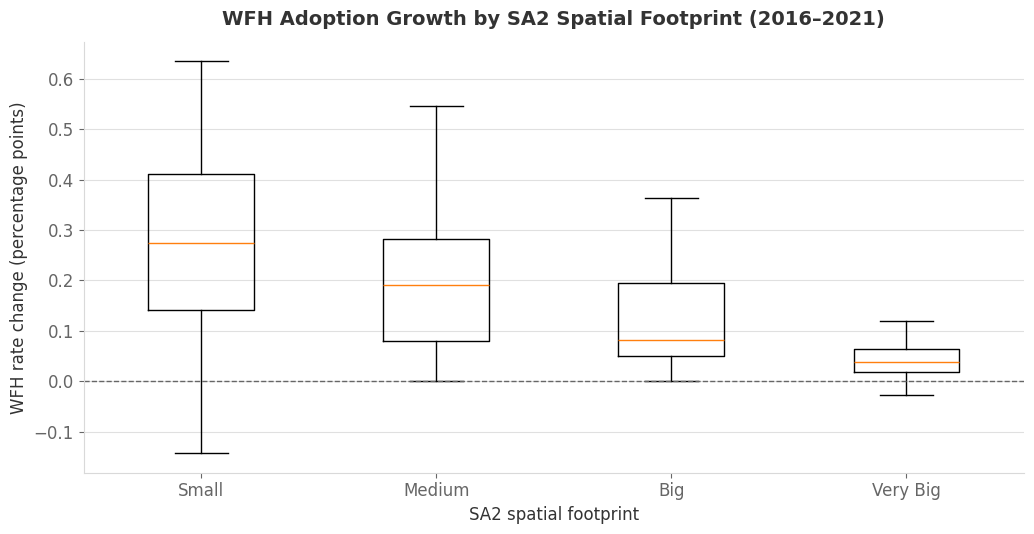

In [ ]:
# ============================================================
# 10) WFH growth by SA2 spatial footprint
# ============================================================

# Optional file; skip gracefully if not present
try:
    df_sa2 = load_csv("V_DIM_SA2.csv", upper_cols=False)

    df_sa2_sub = (
        df_sa2[["sa2_code", "sa2_name", "area_sqkm"]]
        .rename(columns={"sa2_code": "sa2_res_code", "sa2_name": "sa2_res_name_std"})
    )

    df_area = df_wfh_growth.merge(df_sa2_sub, on="sa2_res_code", how="left")

    df_area["area_band"] = pd.cut(
        df_area["area_sqkm"],
        bins=[0, 10, 100, 1000, df_area["area_sqkm"].max()],
        labels=["Small", "Medium", "Big", "Very Big"],
    )

    df_area_plot = df_area.dropna(subset=[pp_col, "area_band"]).copy()

    bands = ["Small", "Medium", "Big", "Very Big"]
    data_by_band = [df_area_plot.loc[df_area_plot["area_band"] == b, pp_col].values for b in bands]

    fig, ax = plt.subplots(figsize=(10.5, 5.5))
    ax.boxplot(data_by_band, labels=bands, showfliers=False)

    ax.set_title("WFH Adoption Growth by SA2 Spatial Footprint (2016–2021)", fontsize=14, weight="bold")
    ax.set_xlabel("SA2 spatial footprint")
    ax.set_ylabel("WFH rate change (percentage points)")
    ax.axhline(0, color=MID_GREY, linestyle="--", linewidth=1)

    clean_axes(ax)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Skipped area-band boxplot (V_DIM_SA2.csv not found).")